In [25]:
import numpy as np
import pandas as pd
import pyproj
import matplotlib.pyplot as plt
import rasterio as rio

In [33]:
def reproject(df, proj_crs):
    lon = df["lon"].to_numpy()
    lat = df["lat"].to_numpy()
    
    #geo_crs = pyproj.CRS.from_proj4("+proj=longlat +a=6051800 +b=6051800 +no_defs ")
    #proj_crs = pyproj.CRS.from_proj4("+proj=eqc +lat_ts=0 +lat_0=0 +lon_0=0 +x_0=0 +y_0=0 +a=6051800 +b=6051800 +units=m +no_defs")
    geo_crs = 'GEOGCS["Mars 2000",DATUM["D_Mars_2000",SPHEROID["Mars_2000_IAU_IAG",3396190.0,169.89444722361179]],PRIMEM["Greenwich",0],UNIT["Degree",0.017453292519943295]]'
    
    proj = pyproj.Transformer.from_crs(geo_crs, proj_crs)
        
    df["x"], df["y"] = proj.transform(lon, lat)
    
    dx = np.gradient(df["x"])
    dy = np.gradient(df["y"])

    theta = np.arctan(dy/dx)
    df["orbit_inc"] = np.rad2deg(theta)
    
    return df

In [34]:
df = pd.read_csv("./ARCDR_alt_10000.csv")

In [40]:
dem_path = "/home/mchristo/proj/simc/dem/MOLA_SHARAD_128ppd_radius_mthellasmask.tif"
dem = rio.open(dem_path, mode="r")
dfr = reproject(df, dem.crs)
dem.close()
print(dfr)

      Unnamed: 0.1  Unnamed: 0   flag  flag_ambig  flag_ambig2  flag_bad  \
0                0           0  32795         0.0          0.0       0.0   
1                1           1  32795         0.0          0.0       0.0   
2                2           2  32795         0.0          0.0       0.0   
3                3           3  32795         0.0          0.0       0.0   
4                4           4  32795         0.0          0.0       0.0   
...            ...         ...    ...         ...          ...       ...   
9995          9995         495  49179         0.0          0.0       0.0   
9996          9996         496  49179         0.0          0.0       0.0   
9997          9997         497  49179         0.0          0.0       0.0   
9998          9998         498  49179         0.0          0.0       0.0   
9999          9999         499  49179         0.0          0.0       0.0   

      flag_badalta  flag_cbad  flag_cmark  flag_ephc  ...  orbit      pradius  \
0     

/tmp/ipykernel_46584/1418191092.py:16: RuntimeWarning: invalid value encountered in divide
  theta = np.arctan(dy/dx)


In [137]:
def crop_footprints(df, raster):
    df["DN_mean"] = np.zeros((len(df))).astype(np.float32)
    df["DN_npix"] = np.zeros((len(df)))
    for i in range(300,len(df)):
        rec = df.iloc[i]
        x0 = rec["x"]
        y0 = rec["y"]
        a = rec["ysize"]*1000/2
        b = rec["xsize"]*1000/2
                
        ymin = y0 - 2*a
        ymax = y0 +2*a
        xmin = x0 - 2*a
        xmax = x0 + 2*a
                                
        A = np.deg2rad(90.0+rec["orbit_inc"])
        inds = rio.open(raster, mode="r")
        win=rio.windows.from_bounds(xmin, ymin, xmax, ymax, inds.transform)
        img = inds.read(1, window=win).astype(np.float32)
        inds.close()

        img[img>255] = np.nan
        img[img<0] = np.nan
        
        cols, rows = np.meshgrid(np.arange(win.col_off, win.col_off+win.width), np.arange(win.row_off, win.row_off+win.height))
        xs, ys = rio.transform.xy(inds.transform, rows, cols)
        ellipse = (((xs-x0)*np.cos(A) + (ys-y0)*np.sin(A))**2 / a**2) + (((xs-x0)*np.sin(A) - (ys-y0)*np.cos(A))**2 / b**2)

        #plt.imshow(img, cmap="Greys")
        #plt.colorbar()
        #plt.contour(ellipse, levels=[1], colors="r")
        
        in_ellipse = img[ellipse<=1.0]
        mean = np.nanmean(in_ellipse)
        num_pix = np.count_nonzero(~np.isnan(img))
        print(np.count_nonzero(ellipse<=1.0))
        rec["DN_mean"] = mean
        rec["DN_npix"] = num_pix
        break
        
    return df

53.60741424560547


IndexError: boolean index did not match indexed array along dimension 0; dimension is 85 but corresponding boolean dimension is 86

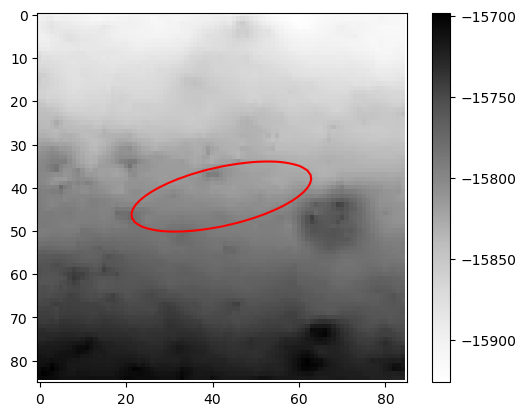

In [138]:
crop_footprints(dfr, dem_path)